<h3 style= "color:blue;"> Importing all the necessary libraries before begining </h3>

In [ ]:
# import required libraries

import pandas as pd # dataframes
import numpy as np #mathematical operations

# to visualise

import plotly.express as px # plotly
from wordcloud import WordCloud # wordclouds
import matplotlib.pyplot as plt #matplot
import seaborn as sns #seaborn
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Vectorisation

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Treating class imbalanced data

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# model building

from sklearn.model_selection import train_test_split

# algorithms

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# checking up with models

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')

from scipy.sparse import hstack

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import joblib
from imblearn.under_sampling import RandomUnderSampler

<h3 style= "color:blue;"> Importing Data Set </h3>

In [3]:
# load your dataframe
df = pd.read_csv("Algorithms/Preprocessed.csv",index_col=[0])

In [4]:
# change both types into string
df['content'] = df['content'].astype('str')
df['fileclass'] = df['fileclass'].astype('str') 

In [5]:
# Replace Cybersecurity value with 1
df.loc[df["fileclass"] == "Cybersecurity", "fileclass"] = 1
df.head(5)

,fileclass,content
0,ChildProtection,trend child sexual abuse material trend child ...
1,ChildProtection,covid remote eliminate female genital mutilati...
2,ChildProtection,journal medium subsequent selfharm followup ch...
3,ChildProtection,original ar sexual exploitation abuse child ph...
4,ChildProtection,covid implication protect child april covid pr...


In [6]:
# Replace other values with 0
df.loc[df["fileclass"] != 1, "fileclass"] = 0

# reorder the dataframe to get childprotection content to appear first
df = df.sort_values(by='fileclass', ascending=False)

df.head(5)

,fileclass,content
45,1,journal build cyber security awareness develop...
47,1,journal southwest university feb issn article ...
34,1,meet problem oct harm digit er metadata proble...
35,1,issue national security review national securi...
36,1,accelerate digitalization critical action resi...


In [7]:
# remove duplicates, leaving the first record
df = df.drop_duplicates(subset=['content'],keep="first")

In [8]:
# spread of text files after removing duplicates
# Count the number of items per group
group_counts = df.groupby("fileclass").count()
group_counts=group_counts.reset_index()

# Create the bar chart
fig = px.bar(group_counts, x='fileclass', y='content',color="fileclass")

# Show the chart
fig.show()

<h3> Word Cloud </h3>

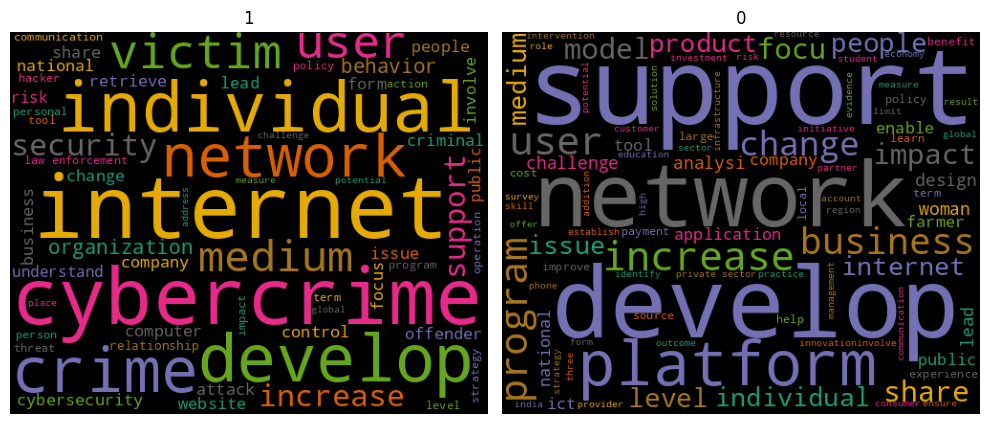

In [9]:
# word clouds based on intervention areas

# Get all the unique classes in the dataset
classes = df['fileclass'].unique()

# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.ravel()

# Iterate through each class
for i, class_name in enumerate(classes):
    # Get all the text for the current class
    class_text = df[df['fileclass'] == class_name]['content'].str.cat(sep=' ')
    # Generate the wordcloud
    wordcloud = WordCloud(width = 500, height = 400, 
                colormap="Dark2",
                min_font_size = 10).generate(class_text) 
    # Plot the wordcloud
    axs[i].imshow(wordcloud) 
    axs[i].set_title(f"{class_name}") 
    axs[i].axis("off") 
fig.tight_layout()
plt.show()

As you can see the data set is class imbalanced.




<b> Now we have to vectorise our content column </b>

In [10]:
# vectorsing the content column
vectorizer = TfidfVectorizer(stop_words=None)
vectorized_df = vectorizer.fit_transform(df['content'])
# defining the y label
y = df['fileclass']
y=y.astype('int')
y=y.to_frame()

In [12]:
class_0_df = df[df['fileclass'] == 0]

# Concatenate the text data from class 0 samples into a single string
class_0_text = ' '.join(class_0_df['content'])

# Tokenize and filter the text data from class 0 samples
class_0_tokens = nltk.word_tokenize(class_0_text)

# Count the frequency of each word in class 0
class_0_word_freq = nltk.FreqDist(class_0_tokens)

# Filter the dataframe to include only class 1 samples
class_1_df = df[df['fileclass'] == 1]

# Concatenate the text data from class 1 samples into a single string
class_1_text = ' '.join(class_1_df['content'])

# Tokenize and filter the text data from class 1 samples
class_1_tokens = nltk.word_tokenize(class_1_text)

# Count the frequency of each word in class 1
class_1_word_freq = nltk.FreqDist(class_1_tokens)

# Get the keywords that are common in class 1 but not common in class 0
k = 10  # Specify the desired number of keywords
keywords = []

for word, frequency in class_1_word_freq.items():
    if word in class_0_word_freq:
        if frequency > class_0_word_freq[word]:
            keywords.append((word, frequency))

# Sort the keywords by frequency in descending order
keywords.sort(key=lambda x: x[1], reverse=True)


# Print the top keywords
for keyword, frequency in keywords[:k]:
    print(keyword, frequency)

security 3546
crime 3403
cyber 3191
cybercrime 2964
cybersecurity 2577
criminal 1943
behavior 1921
victim 1616
threat 1231
attack 1229


In [13]:
keywords= ['security','crime','cyber','cybercrime','cybersecurity','criminal','victim','threat','attack']

In [14]:
# Create binary features for each keyword
for keyword in keywords:
    df[keyword] = np.where(df['content'].str.contains(keyword), 1, 0)

In [15]:
# Concatenate the binary features with the vectorized features
X = hstack([vectorized_df, df[keywords].values])

<h3 style= "color:blue;"> Defining train and test set </h3>

In [16]:
# train test split
X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

<b> Finally we can get rid of class imbalanced data</b>

In [17]:
# treat class imbalanced data
ros = RandomOverSampler(random_state=1500)
X_trainro, Y_trainro = ros.fit_resample(X_train, Y_train)

In [18]:
rus = RandomUnderSampler(random_state=42)
X_trainru, Y_trainru = rus.fit_resample(X_train, Y_train)

<h3 style= "color:blue;"> Fit  Models </h3>

<h3> Random Forest</h3>

In [19]:
# fit the model
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, Y_train.values.ravel())

#make predictions
pred_rf = rf.predict(x_test)

#print accuracy
print("Accuracy %s" % accuracy_score(pred_rf,y_test))

Accuracy 0.918918918918919


In [20]:
print(classification_report(y_test,pred_rf))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       170
           1       0.00      0.00      0.00        15

    accuracy                           0.92       185
   macro avg       0.46      0.50      0.48       185
weighted avg       0.84      0.92      0.88       185



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<h3> Decision Trees </h3>

In [21]:
# fit the model
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, Y_train.values.ravel())

# make predictions
pred_dt = dt.predict(x_test)

# print accuracy 
print("Accuracy %s" % accuracy_score(pred_dt,y_test))

Accuracy 0.9405405405405406


In [22]:
print(classification_report(y_test,pred_dt))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       170
           1       0.75      0.40      0.52        15

    accuracy                           0.94       185
   macro avg       0.85      0.69      0.75       185
weighted avg       0.93      0.94      0.93       185



<h3> Naive Bayes </h3>

In [27]:
# fit the model
nb = MultinomialNB()
nb.fit(X_trainro, Y_trainro.values.ravel())

# make predictions 
pred_nb = nb.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_nb,y_test))

Accuracy 0.7675675675675676


In [28]:
print(classification_report(y_test,pred_nb))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86       170
           1       0.26      1.00      0.41        15

    accuracy                           0.77       185
   macro avg       0.63      0.87      0.63       185
weighted avg       0.94      0.77      0.82       185



<h3> K-Nearest Neighbours </h3>

In [29]:
# fit the model
knn = KNeighborsClassifier()
knn.fit(X_trainro, Y_trainro.values.ravel())

# make predictions
pred_knn = knn.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_knn,y_test))

Accuracy 0.9513513513513514


In [30]:
print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       170
           1       0.67      0.80      0.73        15

    accuracy                           0.95       185
   macro avg       0.82      0.88      0.85       185
weighted avg       0.96      0.95      0.95       185



<h3> Logistic Regression </h3>

In [31]:
# fit the model
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, Y_train.values.ravel())

# make predictions
pred_lr = lr.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_lr,y_test))

Accuracy 0.9459459459459459


In [32]:
print(classification_report(y_test,pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       170
           1       0.62      0.87      0.72        15

    accuracy                           0.95       185
   macro avg       0.80      0.91      0.85       185
weighted avg       0.96      0.95      0.95       185



<h3> Ada Boost </h3>

In [33]:
# fit the model
ab = AdaBoostClassifier()
ab.fit(X_trainro, Y_trainro.values.ravel())

# make predictions
pred_ab = ab.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_ab,y_test))

Accuracy 0.9567567567567568


In [34]:
print(classification_report(y_test,pred_ab))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       170
           1       0.89      0.53      0.67        15

    accuracy                           0.96       185
   macro avg       0.92      0.76      0.82       185
weighted avg       0.95      0.96      0.95       185



<h3> SGD </h3>

In [35]:
# fit the model
sgd = SGDClassifier(class_weight='balanced')
sgd.fit(X_train, Y_train.values.ravel())

# make predictions
pred_sgd = sgd.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_sgd,y_test))

Accuracy 0.9567567567567568


In [36]:
print(classification_report(y_test,pred_sgd))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       170
           1       0.77      0.67      0.71        15

    accuracy                           0.96       185
   macro avg       0.87      0.82      0.85       185
weighted avg       0.95      0.96      0.96       185



<h3> Support Vectore Machine </h3>

In [48]:
# fit the model
svc = SVC(class_weight='balanced')
svc.fit(X_train, Y_train.values.ravel())

# make predictions
pred_svc = svc.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_svc,y_test))

Accuracy 0.9621621621621622


In [49]:
print(classification_report(y_test,pred_svc))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       170
           1       0.79      0.73      0.76        15

    accuracy                           0.96       185
   macro avg       0.88      0.86      0.87       185
weighted avg       0.96      0.96      0.96       185



<h3> Ensemble </h3>

In [39]:
# Create instances of the SGDClassifier and RandomForestClassifier
svc = SVC()
knn = KNeighborsClassifier()

# Create an instance of the VotingClassifier
ensemble = VotingClassifier(estimators=[('svc', svc), ('knn', knn)], voting='hard')

# Fit the VotingClassifier to the data
ensemble.fit(X_train, Y_train.values.ravel())

# Make predictions
pred_ensemble = ensemble.predict(x_test)

# Print accuracy
print("Accuracy %s" % accuracy_score(pred_ensemble, y_test))

Accuracy 0.9675675675675676


In [40]:
print(classification_report(y_test,pred_ensemble))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       170
           1       1.00      0.60      0.75        15

    accuracy                           0.97       185
   macro avg       0.98      0.80      0.87       185
weighted avg       0.97      0.97      0.96       185



<h3 style= "color:blue;"> Conclusion - SGD</h3>

<h3> Hyperparameter Tuning</h3>

In [41]:
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto']}

# Create an instance of the SVC classifier
svc = SVC(class_weight='balanced')

# Set a random seed
np.random.seed(42)

# Create an instance of the GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, Y_train.values.ravel())

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [43]:
# fit the model
svc_cybersecurity = SVC(C=0.10,gamma='scale',class_weight='balanced',kernel='linear')
svc_cybersecurity.fit(X_train, Y_train.values.ravel())

SVC(C=0.1, class_weight='balanced', kernel='linear')

In [44]:
# make predictions on train set
pred_train = svc_cybersecurity.predict(X_train)

# check for accuacy
print("Accuracy of training data set %s" % accuracy_score(pred_train,Y_train))

Accuracy of training data set 0.9162790697674419


In [45]:
# make predictions test set
pred_sgdh = svc_cybersecurity.predict(x_test)

# print accuracy
print("Accuracy of testing data set %s" % accuracy_score(pred_sgdh,y_test))
# get classification report
print(classification_report(y_test,pred_sgdh))

Accuracy of testing data set 0.9351351351351351
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       170
           1       0.56      0.93      0.70        15

    accuracy                           0.94       185
   macro avg       0.78      0.93      0.83       185
weighted avg       0.96      0.94      0.94       185



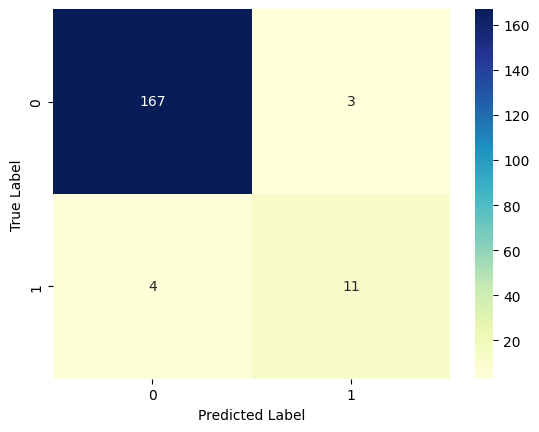

In [47]:

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, pred_svc)


sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Save the model as a pickle in a file
joblib.dump(svc, 'Saved Models/cybersecurity.pkl')